In [1]:
import time
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable
import sys
sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from models import NormalizingFlowModel

In [3]:
rnd_data = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")

testprior_data = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/ThreeProng_5000_500_500.h5")

In [4]:
rnd_data.columns

Index(['Mjj', 'j1 pT', 'j2 pT', 'Mj1', 'j1 tau21', 'j1 tau32', 'j1 tau43',
       'j1 tau54', 'j1 tau65', 'j1 tau76', 'j1 tau87',
       'j1 sqrt(tau^2_1)/tau^1_1', 'j1 n_trk', 'j1 M_trim', 'j1 M_prun',
       'j1 M_mmdt', 'j1 M_sdb1', 'j1 M_sdb2', 'j1 M_sdm1', 'Mj2', 'j2 tau21',
       'j2 tau32', 'j2 tau43', 'j2 tau54', 'j2 tau65', 'j2 tau76', 'j2 tau87',
       'j2 sqrt(tau^2_1)/tau^1_1', 'j2 n_trk', 'j2 M_trim', 'j2 M_prun',
       'j2 M_mmdt', 'j2 M_sdb1', 'j2 M_sdb2', 'j2 M_sdm1', 'isSignal'],
      dtype='object')

In [5]:
dt = rnd_data.values
dt_prior = testprior_data.values

correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt_prior[:,3]>0) &(dt_prior[:,19]>0) & (dt_prior[:,1]>0) & (dt_prior[:,2]>0)
dt_prior = dt_prior[correct]

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

for i in range(13,19):
    dt_prior[:,i] = dt_prior[:,i]/dt_prior[:,3]

for i in range(29,35):
    dt_prior[:,i] = dt_prior[:,i]/(dt_prior[:,19])
#correct = (dt[:,16]>0) & (dt[:,29]>=0) & (dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
#dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
#bkg_idx = np.where(idx==0)[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
correct = (dt[:,0]>=2800)
dt = dt[correct]   

correct = (dt_prior[:,0]>=2800)
dt_prior = dt_prior[correct] 

idx = dt[:,-1]
sig_idx = np.where((dt_prior[:,3]>400) & (dt_prior[:,3]<600) & (dt_prior[:,19]>400) & (dt_prior[:,19]<600) & (dt_prior[:,0]>4500) & (dt_prior[:,0]<5300))[0]
bkg_idx = np.where(idx==0)[0]
#bsmlike = np.where(dt[:,16]>0.9)[0]
#dt = dt[bsmlike]

dt_sig = dt_prior[sig_idx]
dt_bkg = dt[bkg_idx]

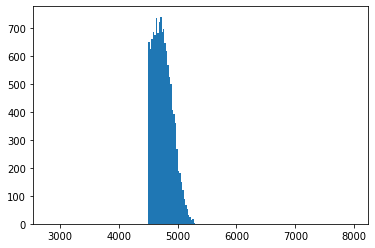

In [6]:
plt.hist(dt_sig[:,0],bins=np.arange(2800,8000,25));

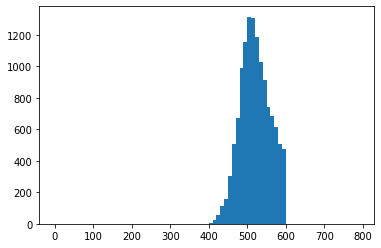

In [7]:
plt.hist(dt_sig[:,3],bins=np.arange(0,800,10));

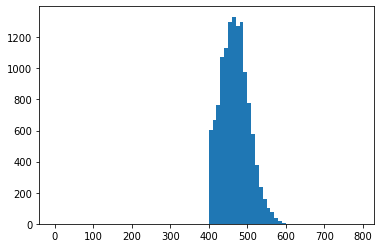

In [8]:
plt.hist(dt_sig[:,19],bins=np.arange(0,800,10));

In [9]:
dt_sig.shape

(12774, 35)

In [10]:
X_12feats = np.concatenate((dt_sig[:,[3,4,5,6,11,12,19,20,21,22,27,28]],dt_bkg[:,[3,4,5,6,11,12,19,20,21,22,27,28]]),axis=0)

X = np.concatenate((dt_sig[:,[4,5,6,11,12,20,21,22,27,28]],dt_bkg[:,[4,5,6,11,12,20,21,22,27,28]]),axis=0)

X_12feats.shape

X.shape

mean_10feats = []
std_10feats = []
for i in range(10):
    mean = np.mean(X[:,i])
    std = np.std(X[:,i])
    mean_10feats.append(mean)
    std_10feats.append(std)
    X[:,i] = (X[:,i]-mean)/std

mean_12feats = []
std_12feats = []
for i in range(12):
    mean = np.mean(X_12feats[:,i])
    std = np.std(X_12feats[:,i])
    mean_12feats.append(mean)
    std_12feats.append(std)
    X_12feats[:,i] = (X_12feats[:,i]-mean)/std

mean_10feats

mean_12feats

idx = dt[:,-1]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

X.shape

y = np.concatenate((np.ones(len(dt_sig[:,0])),np.zeros(len(dt_bkg[:,0]))))

In [11]:
y.shape

(600681,)

In [12]:
X.shape

(600681, 10)

In [13]:
X_12feats.shape

(600681, 12)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42)

In [16]:
print(X_train.shape, X_val.shape, X_test.shape)

(480544, 10) (60068, 10) (60069, 10)


In [17]:
class trainData(utils.Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



## test data    
class testData(utils.Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    



In [18]:
train_data = trainData(torch.FloatTensor(X_train.astype(np.float)),torch.FloatTensor(y_train.astype(np.float)))
val_data = trainData(torch.FloatTensor(X_val.astype(np.float)),torch.FloatTensor(y_val.astype(np.float)))
test_data = testData(torch.FloatTensor(X_test.astype(np.float))) 

In [19]:
import torch

In [20]:
torch.cuda.is_available()

True

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'GeForce GTX 1080 Ti'

In [22]:
BATCH_SIZE = 1000
N_EPOCHS = 80
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

In [23]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(10,84)
        self.linear2 = nn.Linear(84,42)
        self.linear3 = nn.Linear(42,21)
        self.linear4 = nn.Linear(21,10)
        self.linear5 = nn.Linear(10,5)
        self.linear_out = nn.Linear(5,1)
        
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(84)
        self.batchnorm2 = nn.BatchNorm1d(42)
        self.batchnorm3 = nn.BatchNorm1d(21)
        self.batchnorm4 = nn.BatchNorm1d(10)
        self.batchnorm5 = nn.BatchNorm1d(5)
        

    def forward(self, x):
        x = self.batchnorm1(self.linear1(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm2(self.linear2(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm3(self.linear3(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm4(self.linear4(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm5(self.linear5(x))
        x = F.leaky_relu(x)
        x = self.linear_out(x)
        return x





In [24]:
model = Net()

print(model)
model.to(device)

Net(
  (linear1): Linear(in_features=10, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=42, bias=True)
  (linear3): Linear(in_features=42, out_features=21, bias=True)
  (linear4): Linear(in_features=21, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=5, bias=True)
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Net(
  (linear1): Linear(in_features=10, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=42, bias=True)
  (linear3): Linear(in_features=42, out_features=21, bias=True)
  (linear4): Linear(in_features=21, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=5, bias=True)
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [25]:
from torchsummary import summary


In [27]:
summary(model,(10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 84]             924
       BatchNorm1d-2                   [-1, 84]             168
           Dropout-3                   [-1, 84]               0
            Linear-4                   [-1, 42]           3,570
       BatchNorm1d-5                   [-1, 42]              84
           Dropout-6                   [-1, 42]               0
            Linear-7                   [-1, 21]             903
       BatchNorm1d-8                   [-1, 21]              42
           Dropout-9                   [-1, 21]               0
           Linear-10                   [-1, 10]             220
      BatchNorm1d-11                   [-1, 10]              20
          Dropout-12                   [-1, 10]               0
           Linear-13                    [-1, 5]              55
      BatchNorm1d-14                   

In [28]:
# optimizer
#lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [29]:
train_loader = utils.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = utils.DataLoader(dataset=val_data, batch_size=100)
test_loader = utils.DataLoader(dataset=test_data, batch_size=100)

In [30]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [31]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    epoch_loss = 0
    epoch_acc = 0

    for x, y in train_loader:
        # reshape the data into [batch_size, 784]
        x,y = x.to(device), y.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        y_pred = model(x)

        # reconstruction loss
        #recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

        # kl divergence loss
        #kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        #loss = recon_loss + kl_loss

        #BCE loss
        loss = criterion(y_pred, y.unsqueeze(1))
        acc = binary_acc(y_pred, y.unsqueeze(1))
        
        # backward pass
        loss.backward()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # update the weights
        optimizer.step()

    return epoch_loss


In [32]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for x, y in val_loader:
            # reshape the data
            #x = x.view(-1, 28 * 28)
            x,y = x.to(device), y.to(device)
            # forward pass
            y_pred = model(x)

            loss = criterion(y_pred, y.unsqueeze(1))
            acc = binary_acc(y_pred, y.unsqueeze(1))
            # total loss
            
            test_loss += loss.item()

    return test_loss

In [33]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/supervised_ThreeProng5000_500_500_10inputs.h5"))

<All keys matched successfully>

In [56]:
# optimizer
#lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss()

In [57]:
best_test_loss = 999
patience_counter = 0
for e in range(500):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_data)
    test_loss /= len(val_data)

    print(f'Epoch {e}, Train Loss: {train_loss:.7f}, Test Loss: {test_loss:.7f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "/data/t3home000/spark/QUASAR/weights/supervised_ThreeProng5000_500_500_12inputs.h5")
        patience_counter = 1
        print('saving model')
    else:
        print('NOT SAVING')
        patience_counter += 1

    if patience_counter > 10:
        print('patience limit reached')
        break

Epoch 0, Train Loss: 0.0000205, Test Loss: 0.0001832
saving model
Epoch 1, Train Loss: 0.0000204, Test Loss: 0.0001834
NOT SAVING
Epoch 2, Train Loss: 0.0000204, Test Loss: 0.0001838
NOT SAVING
Epoch 3, Train Loss: 0.0000204, Test Loss: 0.0001840
NOT SAVING
Epoch 4, Train Loss: 0.0000204, Test Loss: 0.0001839
NOT SAVING
Epoch 5, Train Loss: 0.0000205, Test Loss: 0.0001847
NOT SAVING
Epoch 6, Train Loss: 0.0000204, Test Loss: 0.0001838
NOT SAVING
Epoch 7, Train Loss: 0.0000206, Test Loss: 0.0001839
NOT SAVING
Epoch 8, Train Loss: 0.0000205, Test Loss: 0.0001836
NOT SAVING
Epoch 9, Train Loss: 0.0000203, Test Loss: 0.0001838
NOT SAVING
Epoch 10, Train Loss: 0.0000203, Test Loss: 0.0001845
NOT SAVING
patience limit reached


In [58]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/supervised_ThreeProng5000_500_500_10inputs.h5"))

<All keys matched successfully>

In [93]:
from sklearn import metrics

In [36]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_list, pos_label=1)

NameError: name 'y_pred_list' is not defined

In [105]:
sup_tpr_np, sup_fpr_np = np.array(tpr), np.array(fpr)
nonzero_idx = np.nonzero(sup_fpr_np)
sup_tpr_inv = sup_tpr_np[nonzero_idx]
sup_fpr_inv = 1/sup_fpr_np[nonzero_idx]

NameError: name 'tpr' is not defined

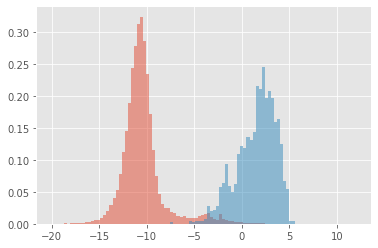

In [34]:
model.eval()
y_pred_list = np.array([],dtype=np.float)
with torch.no_grad():
    for batch_idx, X_batch in enumerate(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_pred_list = np.append(y_pred_list,y_test_pred.cpu().numpy())
        

truesig = np.where(y_test==1)
truebkg = np.where(y_test==0)
sigscore = y_pred_list[truesig]
bkgscore = y_pred_list[truebkg]

plt.style.use('ggplot')

plt.hist(bkgscore,bins=np.linspace(-20,12,101),alpha=.5,density=True);
plt.hist(sigscore,bins=np.linspace(-20,12,101),alpha=.5,density=True);

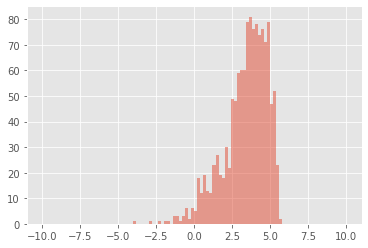

In [38]:
plt.hist(sigscore,bins=np.linspace(-10,10,101),alpha=.5,density=False);

In [43]:
def get_tpr_fpr(sigscore,bkgscore):
    bins = np.linspace(-20,12,10001)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigscore>cut)[0].shape[0]/len(sigscore))
        fpr.append(np.where(bkgscore>cut)[0].shape[0]/len(bkgscore))

    return tpr,fpr

In [40]:
sup_tpr, sup_fpr = get_tpr_fpr(sigscore,bkgscore)
sup_tpr_np, sup_fpr_np = np.array(sup_tpr), np.array(sup_fpr)
nonzero_idx = np.nonzero(sup_fpr_np)
sup_tpr_inv = sup_tpr_np[nonzero_idx]
sup_fpr_inv = 1/sup_fpr_np[nonzero_idx]

(1, 1000000.0)

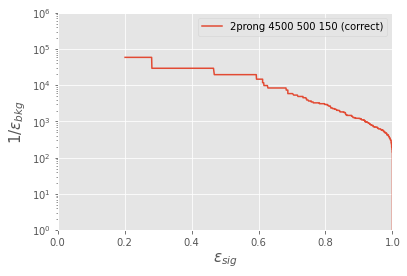

In [41]:
######threeprong
plt.plot(sup_tpr_inv,sup_fpr_inv,label='2prong 4500 500 150 (correct)')
#threeprong_wps = ([4500,300,300],[5000,500,500],[5500,700,700],[6000, 900, 900])
#plt.plot(tprlistsupj1mass_forinverse[4],fprinverselistsupj1mass[4],label='mjj 4000 j1mass 650')
#plt.plot(tprlistsupj1mass_forinverse[5],fprinverselistsupj1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
#plt.title('supervised classifiers on 2 prong signal')
plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
plt.ylim([1,1e6])
#plt.savefig('ROC_Curve_zdim_fnum.png')

In [43]:
import pickle

In [45]:
with open('plot1_supervised_arrays_withmass.pkl','wb') as handle:
    pickle.dump(sup_tpr_inv,handle)
    pickle.dump(sup_fpr_inv,handle)

    

In [35]:
threeprong_wps = ([4500,300,300],[5000,500,500],[5500,700,700],[6000, 900, 900])


In [38]:
supervised_loss_list = []
for mjj, j1mass, j2mass in threeprong_wps:
    supervised_loss = get_loss_from_priors('3prong', mjj, j1mass, j2mass)
    supervised_loss_list.append(supervised_loss)    


In [37]:
def get_loss_from_priors(which_prong, mjj, j1mass, j2mass):
    
   
    filename = {
        
        '2prong':'/data/t3home000/spark/QUASAR/preprocessing/delphes_output',
        '3prong':'/data/t3home000/spark/QUASAR/preprocessing/ThreeProng'            
    
    }
    
    f = pd.read_hdf(f"{filename[which_prong]}_{mjj}_{j1mass}_{j2mass}.h5")
    dt = f.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
    correct = (dt[:,0]>mjj-300) & (dt[:,0]<mjj+300)
    dt = dt[correct]

    correct = (dt[:,3]>j1mass-100) & (dt[:,3]<j1mass+100) & (dt[:,19]>j2mass-100) & (dt[:,19]<j2mass+100)
    dt = dt[correct]
    X_no_jetmass = dt[:,[4,5,6,11,12,20,21,22,27,28]]
    X_with_jetmass = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]


    for i, (mean, std) in enumerate(zip(mean_10feats, std_10feats)):
        X_no_jetmass[:,i] = (X_no_jetmass[:,i]-mean)/std
    
    for i, (mean, std) in enumerate(zip(mean_12feats, std_12feats)):
        X_with_jetmass[:,i] = (X_with_jetmass[:,i]-mean)/std
        

    
    testprior_data = testData(torch.FloatTensor(X_no_jetmass.astype(np.float))) 
    testprior_loader = utils.DataLoader(dataset=testprior_data, batch_size=100)

    tprlist = []
    fprlist = []
    
    y_testpriorlist = []
    

    with torch.no_grad():
        for batch_idx, X_batch in enumerate(testprior_loader):
            X_batch = X_batch.to(device)
            model.eval()
            y_test_pred = model(X_batch)
            #y_test_pred = torch.sigmoid(y_test_pred)
            #y_pred_tag = torch.round(y_test_pred)
            y_testpriorlist = np.append(y_testpriorlist,y_test_pred.cpu().numpy())
        

    return y_testpriorlist

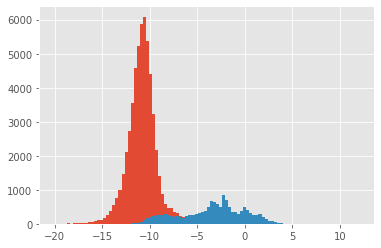

In [41]:
plt.hist(bkgscore,bins=np.linspace(-20,12,101));
plt.hist(supervised_loss_list[0],bins=np.linspace(-20,12,101));

In [47]:
tprlist, fprlist = [], []
for a in supervised_loss_list:
    sup_tpr, sup_fpr = get_tpr_fpr(a,bkgscore)
    sup_tpr_np, sup_fpr_np = np.array(sup_tpr), np.array(sup_fpr)
    nonzero_idx = np.nonzero(sup_fpr_np)
    sup_tpr_inv = sup_tpr_np[nonzero_idx]
    sup_fpr_inv = 1/sup_fpr_np[nonzero_idx]
    tprlist.append(sup_tpr_inv)
    fprlist.append(sup_fpr_inv)
    

In [45]:
threeprong_wps


([4500, 300, 300], [5000, 500, 500], [5500, 700, 700], [6000, 900, 900])

In [54]:
plt.rcParams["figure.figsize"] = (8,8)
plt.style.use('seaborn-bright')

(1, 1000000.0)

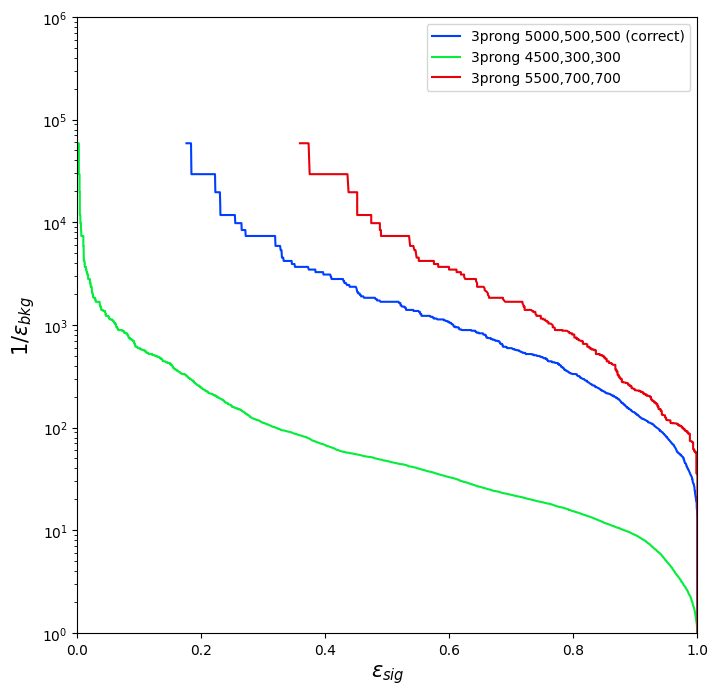

In [55]:
######threeprong
plt.plot(tprlist[1],fprlist[1],label='3prong 5000,500,500 (correct)')
plt.plot(tprlist[0],fprlist[0],label='3prong 4500,300,300')
plt.plot(tprlist[3],fprlist[3],label='3prong 5500,700,700')


#threeprong_wps = ([4500,300,300],[5000,500,500],[5500,700,700],[6000, 900, 900])
#plt.plot(tprlistsupj1mass_forinverse[4],fprinverselistsupj1mass[4],label='mjj 4000 j1mass 650')
#plt.plot(tprlistsupj1mass_forinverse[5],fprinverselistsupj1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
#plt.title('supervised classifiers on 2 prong signal')
plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
plt.ylim([1,1e6])
#plt.savefig('ROC_Curve_zdim_fnum.png')

(1, 1000000.0)

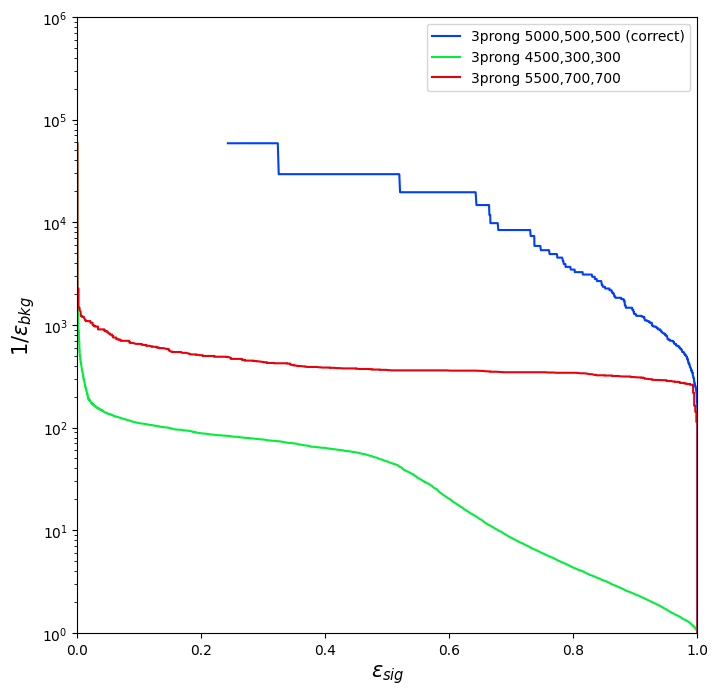

In [73]:
######threeprong
plt.plot(tprlist[1],fprlist[1],label='3prong 5000,500,500 (correct)')
plt.plot(tprlist[0],fprlist[0],label='3prong 4500,300,300')
plt.plot(tprlist[3],fprlist[3],label='3prong 5500,700,700')


#threeprong_wps = ([4500,300,300],[5000,500,500],[5500,700,700],[6000, 900, 900])
#plt.plot(tprlistsupj1mass_forinverse[4],fprinverselistsupj1mass[4],label='mjj 4000 j1mass 650')
#plt.plot(tprlistsupj1mass_forinverse[5],fprinverselistsupj1mass[5],label='mjj 4000 j1mass 700')
#plt.plot(fprlistsigaej1mass[6],tprlistsigaej1mass[6],label='j1mass 850')

#plt.plot(fprlist[2],tprlist[2],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[3],tprlist[3],label='Bkg VAE-Vanilla')
#plt.plot(fprlist[4],tprlist[4],label='mjj 5500')
#plt.plot(fprlist[5],tprlist[5],label='mjj 6000')
#plt.title('supervised classifiers on 2 prong signal')
plt.yscale('log')
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
plt.ylim([1,1e6])
#plt.savefig('ROC_Curve_zdim_fnum.png')